In [1]:
import seaborn as sns
import pandas as pd
import scipy.stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikit_posthocs as sp

In [2]:
demographics_data = pd.read_csv("data/Questionnaire/demographics.csv")
demographics_data.columns = ["Participant", "Sex", "Age", "Familiarity", "Attitude"]
data = pd.read_csv("data/Questionnaire/Questionnaire_responses.csv")
data_long = pd.melt(data, id_vars=["Scenario", "Appearance", "Feeling"], var_name='Participant', value_name='Rating')
data_long["Participant"] = data_long["Participant"].astype(int)
data_wide = data_long.pivot(index=['Participant', 'Scenario', 'Appearance'], columns='Feeling', values='Rating')

full_data = data_long.join(demographics_data.set_index("Participant"), on="Participant")

participants = full_data.groupby("Participant")[["Rating", "Attitude", "Familiarity"]].mean()

# Demographics overview

In [3]:
demographics_data

,Participant,Sex,Age,Familiarity,Attitude
0,1,M,26,5,4
1,2,M,27,3,4
2,3,M,26,4,4
3,4,M,26,4,1
4,5,M,30,4,4
5,6,M,23,3,5
6,7,M,34,4,4
7,8,M,27,5,5
8,9,F,26,3,3
9,10,O,28,4,4


In [4]:
demographics_data.groupby("Sex").size()

Sex
F     7
M    13
O     1
dtype: int64

In [5]:
print(demographics_data.Age.mean(), demographics_data.Age.std())

27.095238095238095 5.512755770980262


In [6]:
demographics_data.groupby("Familiarity").size()

Familiarity
3    10
4     9
5     2
dtype: int64

In [7]:
demographics_data["Attitude"].mean()

3.6666666666666665

Text(0, 0.5, 'Count')

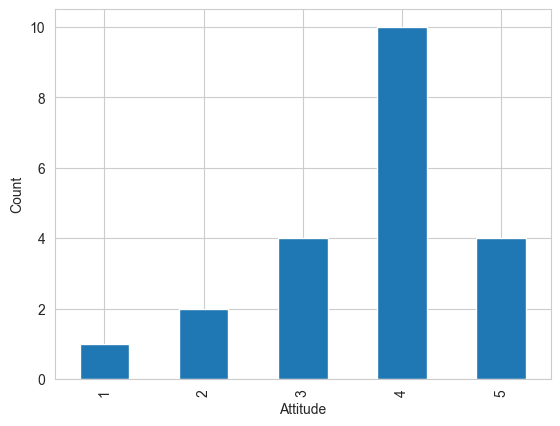

In [8]:
ax = demographics_data["Attitude"].value_counts().sort_index().plot(kind="bar")
ax.set_ylabel("Count")

# Perception questionnaires

## Overall statistics

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

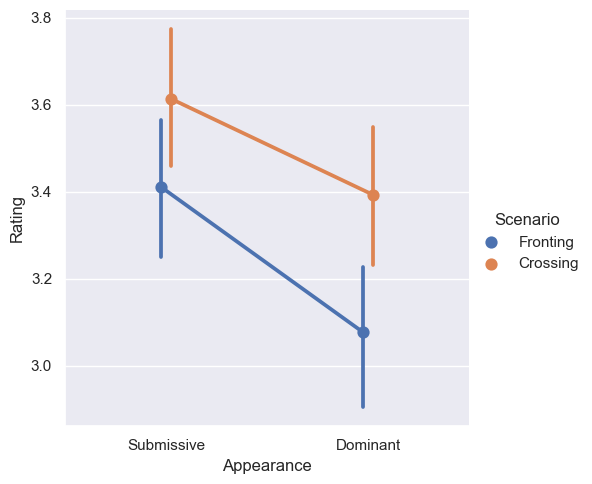

In [9]:
sns.set(font_scale=1)
sns.catplot(data=data_long, y="Rating", x="Appearance", hue="Scenario", kind="point", dodge=True)

### Simple t-tests (ignoring possible interaction between appearance and scenario) 

In [10]:
data_long[data_long.Appearance=="Submissive"].Rating.mean(), data_long[data_long.Appearance=="Dominant"].Rating.mean()

(3.511904761904762, 3.2351190476190474)

In [11]:
scipy.stats.ttest_rel(data_long[data_long.Appearance=="Submissive"].Rating, data_long[data_long.Appearance=="Dominant"].Rating)

TtestResult(statistic=4.546036246269203, pvalue=7.64650225782735e-06, df=335)

In [12]:
data_long[data_long.Scenario=="Crossing"].Rating.mean(), data_long[data_long.Scenario=="Fronting"].Rating.mean()

(3.5029761904761907, 3.244047619047619)

In [13]:
scipy.stats.ttest_rel(data_long[data_long.Scenario=="Crossing"].Rating, data_long[data_long.Scenario=="Fronting"].Rating)

TtestResult(statistic=5.772495399239405, pvalue=1.7809904284727847e-08, df=335)

### (not sure about this one) Statsmodels ANOVA + scikit_posthoc posthocs

In [14]:
model = ols(
    'Rating ~ C(Scenario) + C(Appearance) + C(Feeling)', data=data_long).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Scenario),11.263393,1.0,11.309407,0.000816
C(Appearance),12.870536,1.0,12.923115,0.000349
C(Feeling),25.808036,7.0,3.701924,0.000615
Residual,659.306548,662.0,NaN,NaN


In [15]:
sp.posthoc_ttest(data_long, val_col='Rating', group_col='Scenario', p_adjust='bonf')

,Fronting,Crossing
Fronting,1.000000,0.001061
Crossing,0.001061,1.000000


In [16]:
sp.posthoc_ttest(data_long, val_col='Rating', group_col='Appearance', p_adjust='bonf')

,Submissive,Dominant
Submissive,1.000000,0.000463
Dominant,0.000463,1.000000


### Statsmodels ANOVA

In [17]:
model = ols(
    'Calming ~ C(Scenario) + C(Appearance) + C(Appearance):C(Scenario)', data=data_wide.reset_index()).fit()
sm.stats.anova_lm(model, typ=2)
# sp.posthoc_ttest(data_wide.reset_index(), val_col='Sepal.Width', group_col='Species', p_adjust='holm')

,sum_sq,df,F,PR(>F)
C(Scenario),1.190476,1.0,1.540832,0.218121
C(Appearance),4.761905,1.0,6.163328,0.015135
C(Appearance):C(Scenario),0.190476,1.0,0.246533,0.620888
Residual,61.809524,80.0,NaN,NaN


## Per-attribute ratings

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

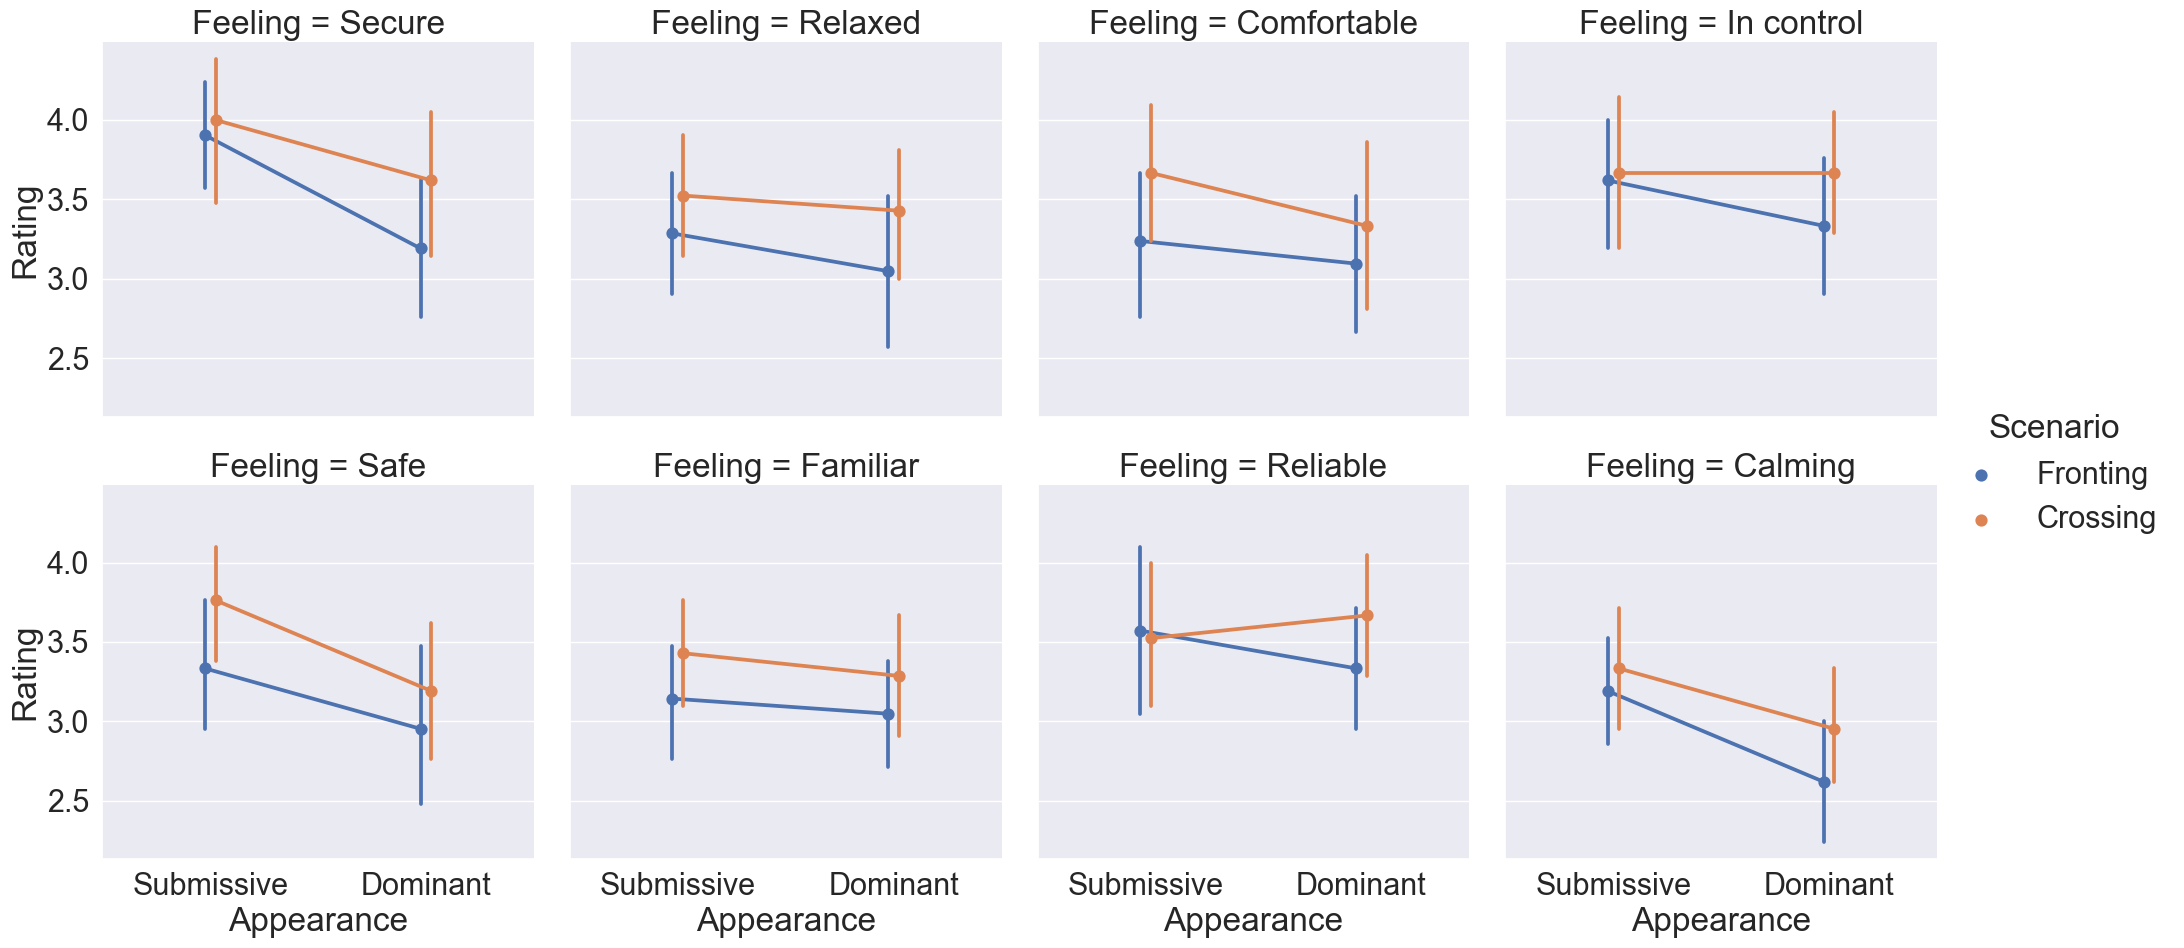

In [18]:
sns.set(font_scale=2)
sns.catplot(data=data_long, y="Rating", x="Appearance", col="Feeling", hue="Scenario", col_wrap=4, kind="point", dodge=True)

### Statsmodels ANOVAs

In [19]:
model = ols(
    'Secure ~ C(Scenario) + C(Appearance)', data=data_wide.reset_index()).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Scenario),1.440476,1.0,1.379451,0.243636
C(Appearance),6.297619,1.0,6.030823,0.016198
Residual,84.583333,81.0,NaN,NaN


### t-tests: Fronting vs Crossing

In [20]:
for var in data_wide.columns:
    print(var)
    print(scipy.stats.ttest_rel(data_wide.loc[:, "Fronting", :][var], data_wide.loc[:, "Crossing", :][var])[0])
    print(scipy.stats.ttest_rel(data_wide.loc[:, "Fronting", :][var], data_wide.loc[:, "Crossing", :][var])[1]*8)    

Calming
-2.0329939783799245
0.38849730374420904
Comfortable
-2.471109665458699
0.14172071033091627
Familiar
-2.7070126121108182
0.0788212264891908
In control
-1.386994472119175
1.3835051544334014
Relaxed
-1.8353467825858087
0.5897232665712071
Reliable
-1.1378650368586174
2.09426153748683
Safe
-2.994787137677735
0.03712994314718893
Secure
-2.212992238928048
0.26018694056616776


### t-tests Submissive vs Dominant

In [21]:
for var in data_wide.columns:
    print(var)
    print(scipy.stats.ttest_rel(data_wide.loc[:, :, "Submissive"][var], data_wide.loc[:, :, "Dominant"][var])[0])
    print(scipy.stats.ttest_rel(data_wide.loc[:, :, "Submissive"][var], data_wide.loc[:, :, "Dominant"][var])[1]*8)

Calming
2.898558149194577
0.047963075143784936
Comfortable
1.2196980282496606
1.8363950454079063
Familiar
1.0436794227698865
2.421988983931931
In control
0.7460302178684524
3.679243283695354
Relaxed
0.9426265918383941
2.8111475810328432
Reliable
0.2511511956509924
6.423613733549711
Safe
2.781339435704275
0.0651381981663214
Secure
3.4896976793582506
0.009362912934386094


## Ratings depending on prior attitude

In [22]:
participants["attitude_q"] = pd.cut(participants.Attitude, 2, labels=["Negative", "Positive"])

In [23]:
participants.attitude_q.value_counts()

attitude_q
Positive    14
Negative     7
Name: count, dtype: int64

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='attitude_q', ylabel='Rating'>

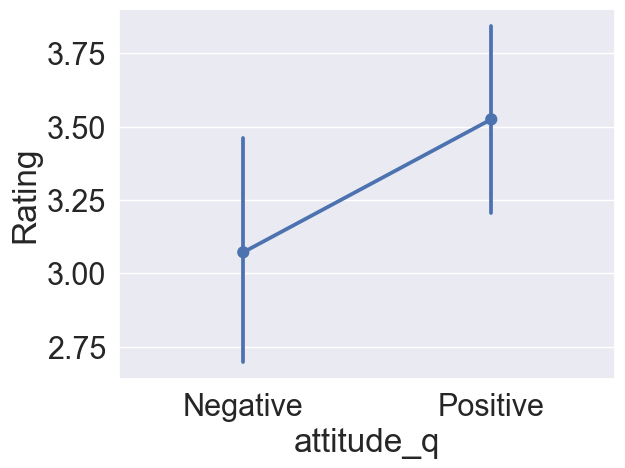

In [24]:
sns.pointplot(data=participants, x="attitude_q", y="Rating")

<Axes: xlabel='Attitude', ylabel='Rating'>

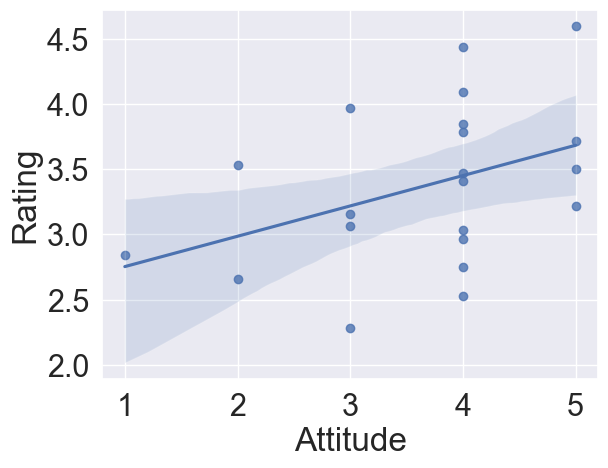

In [25]:
sns.regplot(data=participants, x="Attitude", y="Rating")

In [26]:
model = ols('Rating ~ Attitude', data=participants).fit()

In [27]:
model.params, model.tvalues, model.pvalues

(Intercept    2.520877
 Attitude     0.232537
 dtype: float64,
 Intercept    5.442674
 Attitude     1.913342
 dtype: float64,
 Intercept    0.000030
 Attitude     0.070894
 dtype: float64)